# epitopepredict API basic usage

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins you should provide a path so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in csv format. Results can be loaded into the predictor individually or all together using the `load` method.

In [1]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
import epitopepredict as ep
from epitopepredict import sequtils, tepitope, plotting, utilities, peptutils
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt

In [2]:
#get preset alleles
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')
m1_alleles = ep.get_preset_alleles('mhc1_supertypes')
print (m1_alleles)
print (m2_alleles)

['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*24:02', 'HLA-B*07:02', 'HLA-B*44:03']
['HLA-DRB1*01:01', 'HLA-DRB1*03:01', 'HLA-DRB1*04:01', 'HLA-DRB1*07:01', 'HLA-DRB1*08:01', 'HLA-DRB1*11:01', 'HLA-DRB1*13:01', 'HLA-DRB1*15:01']


## predict random peptides

In [3]:
seqs = peptutils.create_random_sequences(10)
print (seqs[:5])
df = pd.DataFrame(seqs,columns=['peptide'])
P = ep.get_predictor('basicmhc1')
b = P.predict_peptides(df.peptide, alleles=m1_alleles, show_cmd=True, cpus=1)

['PHKDEAIYS', 'VKMVVEWMS', 'VDHPIKVQF', 'FNYSGMGSY', 'TAICDLPVI']


## results are returned as dataframes, sorted by score

In [4]:
print (b[:5])

     peptide  pos  log50k     score  name       allele  rank
0  FNYSGMGSY    3  0.3656    957.25  temp  HLA-A*01:01   1.0
1  ILGMLVIRA    6  0.1113  14995.97  temp  HLA-A*01:01   2.0
2  VKMVVEWMS    1  0.1049  16071.19  temp  HLA-A*01:01   3.0
3  PHKDEAIYS    0  0.1042  16193.37  temp  HLA-A*01:01   4.0
4  TAICDLPVI    4  0.0928  18319.16  temp  HLA-A*01:01   5.0


## predict n-mers from a protein sequence
This example loads protein sequences from mycobacterium tuberculosis from a genbank file

In [8]:
#load protein sequences into a dataframe
prots = ep.genbank_to_dataframe('../MTB-H37Rv.gb',cds=True)
prots[:5]

,type,protein_id,locus_tag,gene,db_xref,product,note,translation,pseudo,start,end,strand,length,order
2,CDS,CCP42723.1,Rv0001,dnaA,GI:444893470,Chromosomal replication initiator protein DnaA,"Rv0001, (MT0001, MTV029.01, P49993), len: 507 ...",MTDDPGSGFTTVWNAVVSELNGDPKVDDGPSSDANLSAPLTPQQRA...,NaN,0,1524,1,507,1
4,CDS,CCP42724.1,Rv0002,dnaN,GI:444893471,DNA polymerase III (beta chain) DnaN (DNA nucl...,"Rv0002, (MTV029.02, MTCY10H4.0), len: 402 aa. ...",MDAATTRVGLTDLTFRLLRESFADAVSWVAKNLPARPAVPVLSGVL...,NaN,2051,3260,1,402,2
6,CDS,CCP42725.1,Rv0003,recF,GI:444893472,DNA replication and repair protein RecF (singl...,"Rv0003, (MTCY10H4.01), len: 385 aa. RecF, DNA ...",MYVRHLGLRDFRSWACVDLELHPGRTVFVGPNGYGKTNLIEALWYS...,NaN,3279,4437,1,385,3
8,CDS,CCP42726.1,Rv0004,NaN,GI:444893473,Conserved hypothetical protein,"Rv0004, (MTCY10H4.02), len: 187 aa. Conserved ...",MTGSVDRPDQNRGERSMKSPGLDLVRRTLDEARAAARARGQDAGRG...,NaN,4433,4997,1,187,4
10,CDS,CCP42727.1,Rv0005,gyrB,GI:444893474,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",MAAQKKKAQDEYGAASITILEGLEAVRKRPGMYIGSTGERGLHHLI...,NaN,5239,7267,1,675,5


In [9]:
P = ep.get_predictor('tepitope')
mb_binders = P.predict_sequences(prots[:20], alleles=m2_alleles, cpus=1)

predictions done for 20 sequences in 8 alleles


In [10]:
mb_binders.head()

,peptide,core,pos,score,name,allele,rank
174,DTFVIGASNRF,FVIGASNRF,174,2.00,Rv0001,HLA-DRB1*0101,1.0
175,TFVIGASNRFA,FVIGASNRF,175,2.00,Rv0001,HLA-DRB1*0101,1.0
176,FVIGASNRFAH,FVIGASNRF,176,2.00,Rv0001,HLA-DRB1*0101,1.0
45,AWLNLVQPLTI,LNLVQPLTI,45,1.55,Rv0001,HLA-DRB1*0101,4.0
46,WLNLVQPLTIV,LNLVQPLTI,46,1.55,Rv0001,HLA-DRB1*0101,4.0


## get promiscuous binders - those peptides above the cutoff for at least 3 alleles

In [5]:
pb = P.promiscuous_binders(n=3)
pb.shape

(0, 8)

In [11]:
print (pb[:3])

Empty DataFrame
Columns: [peptide, pos, name, alleles, core, score, mean, median_rank]
Index: []


## plot binders in a protein sequence

['Rv0001', 'Rv0002', 'Rv0003', 'Rv0004', 'Rv0005', 'Rv0006', 'Rv0007', 'Rv0008c', 'Rv0009', 'Rv0010c', 'Rv0011c', 'Rv0012', 'Rv0013', 'Rv0014c', 'Rv0015c', 'Rv0016c', 'Rv0017c', 'Rv0018c', 'Rv0019c', 'Rv0020c']
Rv0011c tepitope 82 11 93


<Figure size 432x288 with 0 Axes>

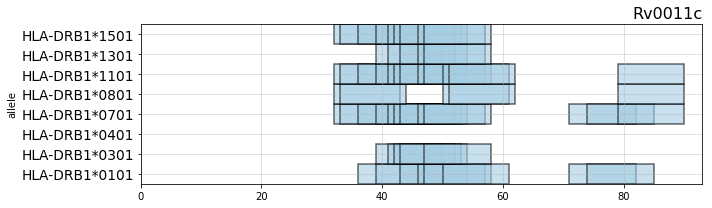

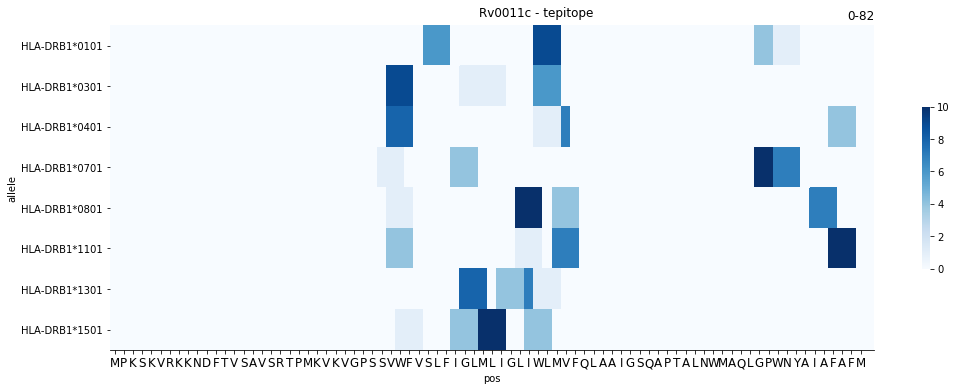

In [12]:
#get names of proteins stored in results of predictor
print (P.get_names())
ax = plotting.plot_tracks([P],name='Rv0011c',cutoff=.94,n=2)
plt.tight_layout()
plt.savefig('mhc_rv0011c.png',dpi=150)
ax = plotting.plot_binder_map(P,name='Rv0011c',cutoff=10)
plt.savefig('mhc_rv0011c_map.png',dpi=150)

In [13]:
reload(plotting)
from bokeh.io import show, output_notebook
output_notebook()
p = plotting.bokeh_plot_tracks([P],name='Rv0011c',cutoff=.95,n=2,width=800)
show(p)

Loading BokehJS ...

/usr/local/lib/python3.6/dist-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):
